# Exploring Numerical Outcome Measures

As multiple outcome measures were gathered when sampling the infants, it will be interesting to see if we can relate them to the microbiome composition. 
In this notebook we will explore the outcome measures and see what analysis may be promising.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as sts 

from qiime2 import Artifact

data_dir = "../data"

plt.style.use("../presentation_style")

%matplotlib inline

In [2]:
metadata_per_sample = pd.read_csv(
    f"{data_dir}/raw/metadata_per_sample.tsv", sep="\t", index_col="sampleid"
)
metadata_per_sample["infant_id"] = metadata_per_sample["infant_id"].astype("category")

metadata_per_age = pd.read_csv(
    f"{data_dir}/raw/metadata_per_age.tsv", sep="\t", index_col=0
)

metadata = (
    metadata_per_sample.reset_index()
    .merge(right=metadata_per_age, how="left", on=["infant_id", "timepoint"])
    .set_index("sampleid")
)
metadata.head()

,infant_id,timepoint,sample_number,age_days,sex,feeding_method,birth_mode,collection_date,collection_site,behavioral_development,parent_attuned_caring_style,sleep_rhythmicity,sleep_quality
sampleid,,,,,,,,,,,,,
sample_1,1,2 months,1,69,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522
sample_2,1,2 months,2,69,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522
sample_3,1,2 months,3,69,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522
sample_4,1,2 months,4,70,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522
sample_5,1,2 months,5,71,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522


In [3]:
metadata.dtypes

infant_id                        int64
timepoint                       object
sample_number                    int64
age_days                         int64
sex                             object
feeding_method                  object
birth_mode                      object
collection_date                  int64
collection_site                 object
behavioral_development         float64
parent_attuned_caring_style    float64
sleep_rhythmicity              float64
sleep_quality                  float64
dtype: object

## Correlations between Outcome Measures

We will first look into the distributions of the outcome measures and variable `age_days` additionally using histograms.

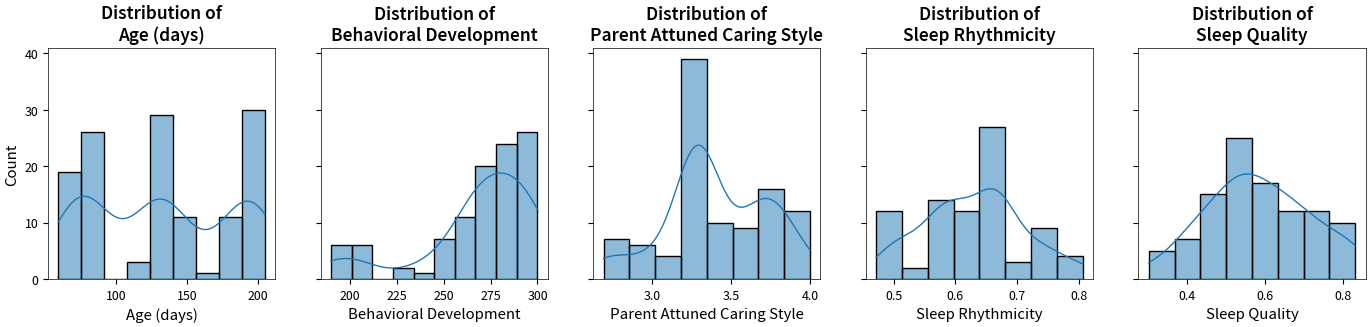

In [4]:
outcome_measures = ["age_days", "behavioral_development", "parent_attuned_caring_style", "sleep_rhythmicity", "sleep_quality"]
outcome_measures_label_dict = {
    "age_days": "Age (days)",
    "behavioral_development": "Behavioral Development",
    "parent_attuned_caring_style": "Parent Attuned Caring Style",
    "sleep_rhythmicity": "Sleep Rhythmicity",
    "sleep_quality": "Sleep Quality"
}
fig, axs = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(17, 3))

for i, ax in enumerate(axs.flatten()):
    try:
        sns.histplot(
            x=outcome_measures[i],
            data=metadata,
            kde=True,
            ax=ax
        )

        ax.set_title(f"Distribution of\n{outcome_measures_label_dict[outcome_measures[i]]}")
        ax.set_xlabel(outcome_measures_label_dict[outcome_measures[i]])
        
        if i not in [0, 3]:
            ax.set_ylabel(None)

    except IndexError: # remove empty plot as odd number of variables plotted
        fig.delaxes(axs.flatten()[-1])

Sleep quality seems to follow a near normal distribution. This is confirmed by the QQ-Plot below. It plots the quantiles of a variable against the quantiles of a reference distribution, in this case a normal distribution. The closer the points lie on the red line, the better the assumption that the data follows a normal distribution. All other variables than `sleep_quality` should not be assumed to follow a normal distribution.

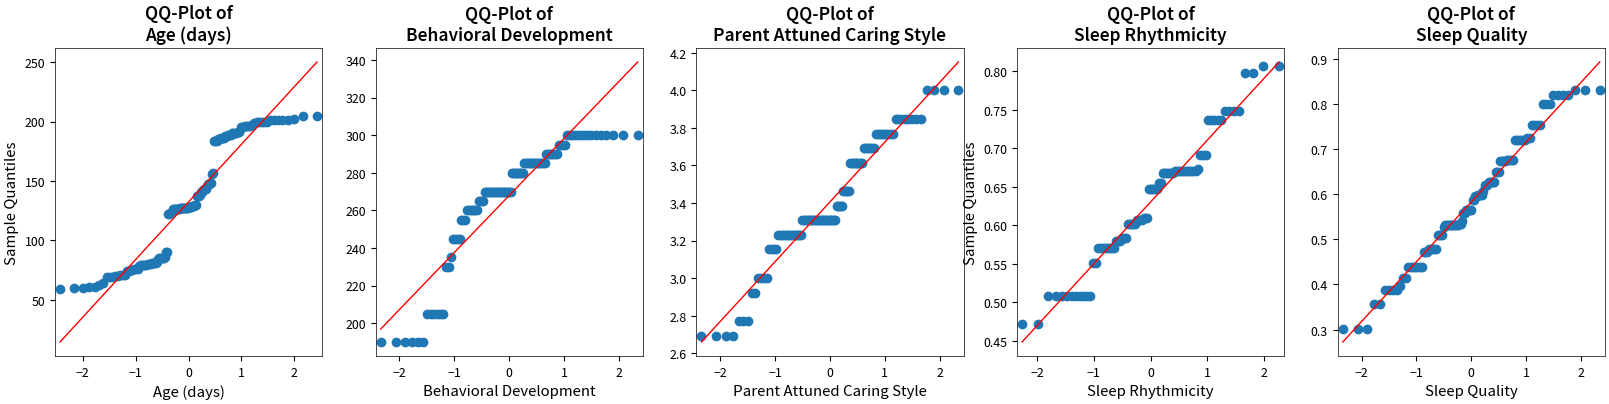

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

for i, ax in enumerate(axs.flatten()):
    qqplot(
        data=metadata[outcome_measures[i]].dropna(),
        line='s',
        ax=ax
    )

    ax.set_title(f"QQ-Plot of\n{outcome_measures_label_dict[outcome_measures[i]]}")
    ax.set_xlabel(outcome_measures_label_dict[outcome_measures[i]])
    
    if i not in [0, 3]:
        ax.set_ylabel(None)

This pairplot shows us the pairwise relationship between the variables. Overall, most scatterplots seem to follow a random pattern and no clear relationships can be determined. We will look at correlations in a more informative manner below using a heatmap.

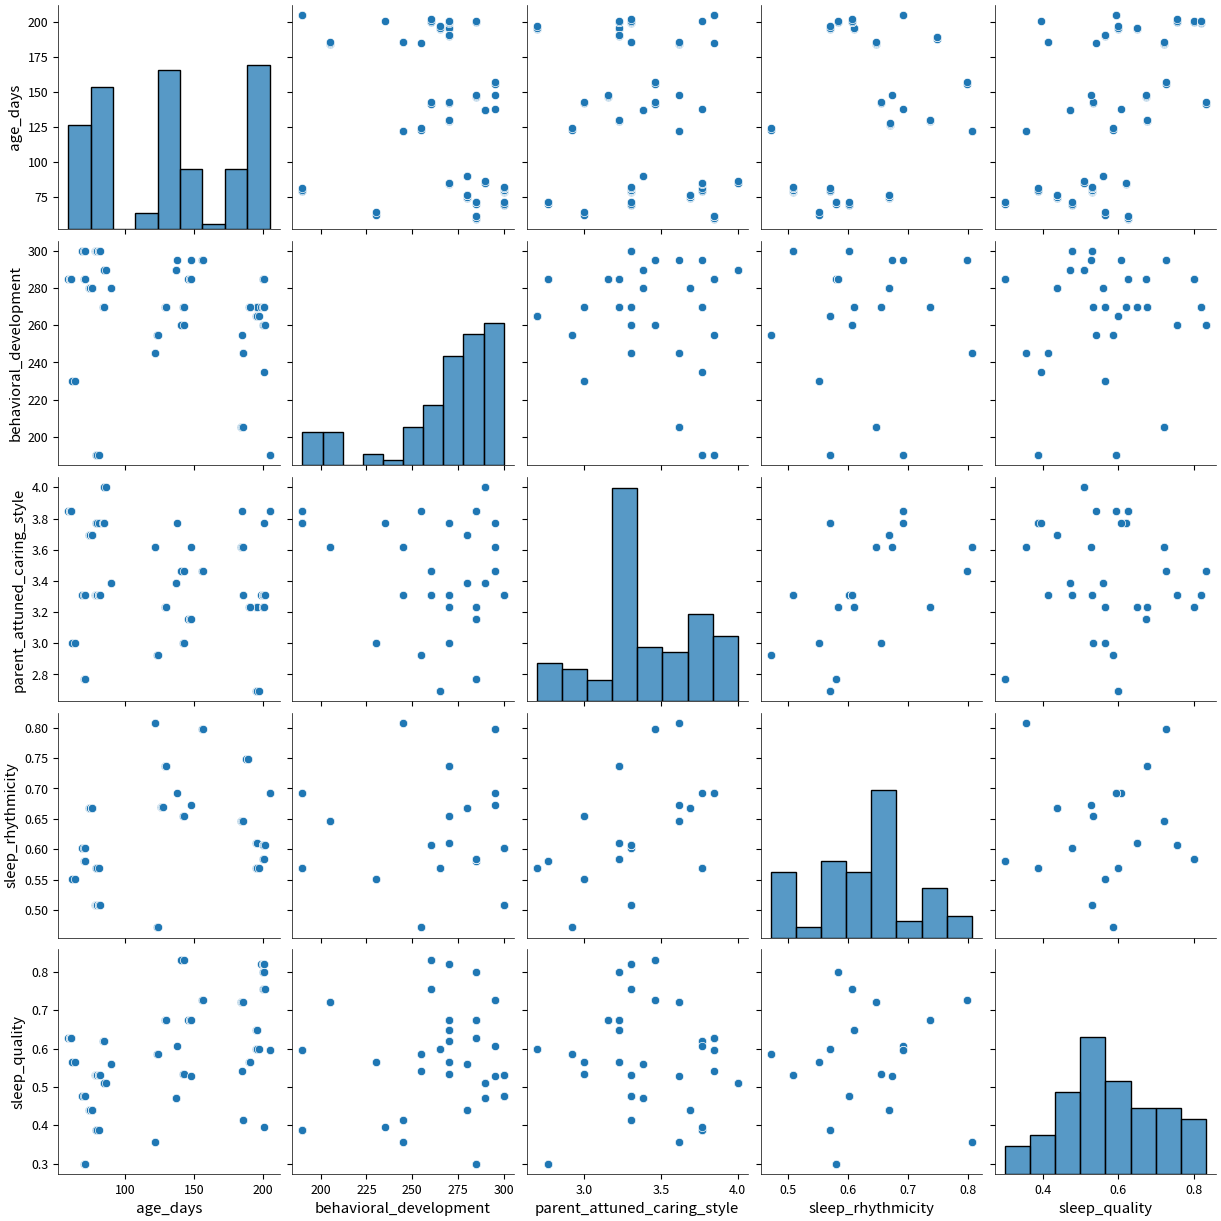

In [6]:
pplot = sns.pairplot(
    data=metadata,
    x_vars=outcome_measures, y_vars=outcome_measures,
)

The following heatmap shows the pearson correlation of all variables and the p-value of the correlation test.

- Sleep quality and sleep rhtyhmicity seems to correlate positively with age, which is to be expected. Most parents can probably tell a story about newborns sleeping irregularly and requiring lots of attention. Sleep Rithmetic city also correlates positively with the caring style of parents.
- The behavioural development score correlates negatively with age. This might be interesting to look at as we have discovered temporal trajectories in microbiome development. Maybe we can link these two aspects of infant development.

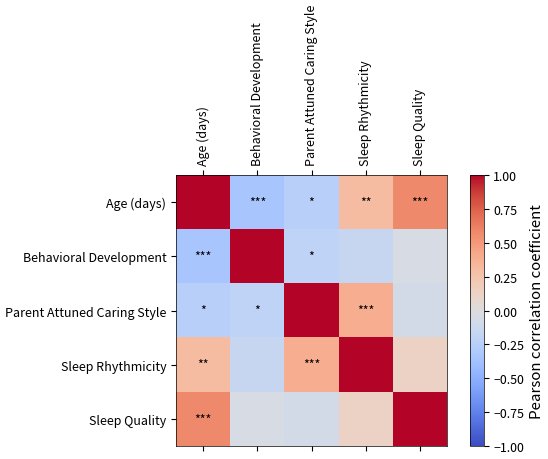

In [7]:
# Here we compute the Pearson correlation matrix
correlation_matrix = metadata.loc[:, outcome_measures].corr(method="pearson") 

# Here we compute the significance matrix (p-values) of the correlations
corr_signinicance_matrix = metadata.loc[:, outcome_measures].corr(
    method=lambda x, y: sts.pearsonr(x, y)[1]
    )

# Translate p-values into significance levels
corr_signinicance_matrix = corr_signinicance_matrix.applymap(
    lambda p: "" if p > 0.05 else ("*" if p > 0.01 else ("**" if p > 0.001 else "***"))
    )

fig, ax = plt.subplots(1, 1)
cax = ax.matshow(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
fig.colorbar(cax, label="Pearson correlation coefficient")

for (i, j), z in np.ndenumerate(corr_signinicance_matrix):
    ax.text(j, i, z, ha='center', va='center')

ax.set_xticklabels(['']+list(outcome_measures_label_dict.values()), rotation=90)
ax.set_yticklabels(['']+list(outcome_measures_label_dict.values()))

fig.tight_layout()
fig.show()

## Linear Mixed Effects Models

We will now use Linear Mixed Effects (LME) models to test the effect of Shannon diversity on the outcome measures, while controlling for age and infant ID. We use the `longitudinal` plugin from QIIME 2. This allows us to account for the repeated measures design (multiple samples per infant) and the effect of age on the outcome measures.

In [8]:
from qiime2 import Metadata
from qiime2.plugins.longitudinal.actions import linear_mixed_effects

# Load Shannon diversity
shannon_artifact = Artifact.load(f"{data_dir}/raw/boots_kmer_diversity_collapsed/alpha_diversities/shannon.qza")
shannon_series = shannon_artifact.view(pd.Series)
shannon_series.name = 'shannon_entropy'

# Ensure indices are strings for merging to avoid type mismatches
metadata_collapsed = pd.read_csv(
    f"{data_dir}/raw/metadata_collapsed.tsv", sep="\t"
)

# Add prefix to infant_id
metadata_collapsed["infant_id"] = "infant_" + metadata_collapsed["infant_id"].astype(str)

# Merge with metadata
# We use the existing metadata dataframe and merge the shannon diversity
metadata_with_shannon = metadata_collapsed.merge(shannon_series, left_on="sampleid", right_index=True).set_index("sampleid")

print(f"Metadata rows: {len(metadata_collapsed)}")
print(f"Shannon rows: {len(shannon_series)}")
print(f"Merged rows: {len(metadata_with_shannon)}")

# Ensure age_days is numeric
metadata_with_shannon['age_days'] = pd.to_numeric(metadata_with_shannon['age_days'], errors='coerce')

# Run LME for each outcome measure
lme_results = {}

for outcome in outcome_measures:
    if outcome == 'age_days':
        continue
        
    print(f"Running LME for {outcome}...")
    
    # Create QIIME 2 Metadata object
    # We drop NaNs for the current outcome to avoid errors in LME
    # We also ensure we have the necessary columns
    current_df = metadata_with_shannon.dropna(subset=[outcome, 'shannon_entropy', 'age_days'])
    
    if len(current_df) == 0:
        print(f"  No valid samples for {outcome} (after dropping NaNs). Skipping.")
        continue

    current_md = Metadata(current_df)
    
    # Formula: outcome ~ shannon_entropy + age_days
    # We control for age_days as a fixed effect. 
    # infant_id is handled as a random effect by specifying individual_id_column.
    # NOTE: QIIME 2 requires the state_column (age_days) to be in the formula.
    formula = f"{outcome} ~ shannon_entropy + age_days"
    
    try:
        lme_viz, = linear_mixed_effects(
            metadata=current_md,
            state_column="age_days", # Changed from "timepoint" to "age_days"
            individual_id_column="infant_id",
            metric=outcome,
            formula=formula
        )
        
        # Save the visualization
        out_path = f"{data_dir}/processed/lme_shannon_{outcome}.qzv"
        lme_viz.save(out_path)
        lme_results[outcome] = out_path
        print(f"  Saved to {out_path}")
        
    except Exception as e:
        print(f"  Error running LME for {outcome}: {e}")

Metadata rows: 36
Shannon rows: 35
Merged rows: 35
Running LME for behavioral_development...
  Saved to ../data/processed/lme_shannon_behavioral_development.qzv
Running LME for parent_attuned_caring_style...
  Saved to ../data/processed/lme_shannon_behavioral_development.qzv
Running LME for parent_attuned_caring_style...
  Saved to ../data/processed/lme_shannon_parent_attuned_caring_style.qzv
Running LME for sleep_rhythmicity...
  Saved to ../data/processed/lme_shannon_parent_attuned_caring_style.qzv
Running LME for sleep_rhythmicity...


/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


  Saved to ../data/processed/lme_shannon_sleep_rhythmicity.qzv
Running LME for sleep_quality...


/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


  Saved to ../data/processed/lme_shannon_sleep_quality.qzv


### Explanation of Model Parameters

**1. The Formula: `outcome ~ shannon_entropy + age_days`**
*   **Dependent Variable (`outcome`)**: This is the variable we are trying to explain (e.g., `sleep_quality`).
*   **Fixed Effects (`shannon_entropy + age_days`)**:
    *   `shannon_entropy`: This is our main predictor of interest. We want to know if diversity is associated with the outcome.
    *   `age_days`: We include age as a covariate (control variable). We know that both the microbiome (diversity increases) and infant development (sleep patterns mature) change significantly with age. By including it in the formula, we "control" for it, asking: *"Independent of the child's age, does having a higher diversity correlate with better sleep?"*
*   **Alternatives**:
    *   *Interaction Term (`outcome ~ shannon_entropy * age_days`)*: This would test if the relationship between diversity and sleep *changes* as the child gets older.
    *   *Removing Age (`outcome ~ shannon_entropy`)*: This would likely yield misleading results (confounding). You might find a strong correlation simply because older babies have both higher diversity and better sleep, not because diversity causes better sleep.

**2. `individual_id_column="infant_id"` (Random Effects)**
*   This parameter tells the model that multiple samples belong to the same infant.
*   **Random Intercepts**: The model adds a specific "baseline" value for each infant. Some infants might just naturally be better sleepers or have higher diversity regardless of time. This accounts for the non-independence of data points (repeated measures).
*   **Effect**: If we treated every sample as independent (standard linear regression), we would violate statistical assumptions and likely get false positives (p-values that are too low).

Text(0.5, 0.93, 'Relationship between Shannon Entropy and Outcome Measures')

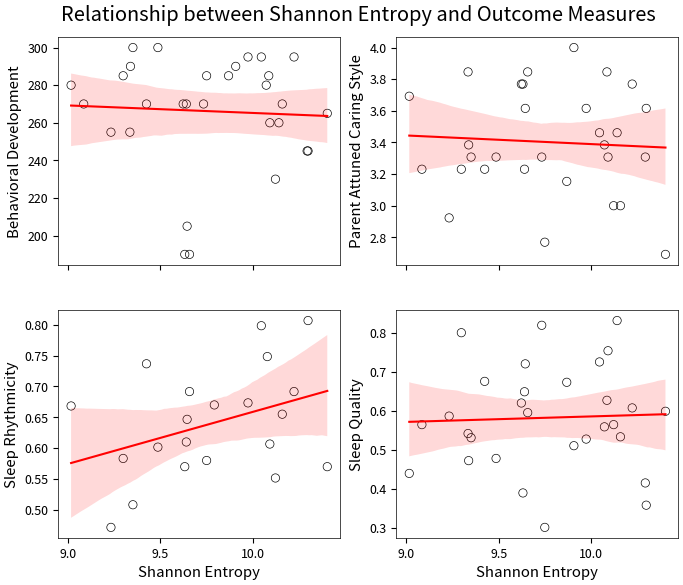

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6.5), sharex=True)

for i, outcome in enumerate(outcome_measures):
    if outcome == 'age_days':
        continue
        
    current_md = metadata_with_shannon.dropna(subset=[outcome, 'shannon_entropy', 'age_days'])
    
    ax = axs.flatten()[i-1]
    if i == 4:
        sns.scatterplot(
            data=current_md,
            x='shannon_entropy',
            y=outcome,
            # size="age_days",
            # palette="Blues",
            marker="o",
            facecolor="none",
            edgecolor="black",
            legend="brief",
            ax=ax
        )
        # ax.legend(title="Age (days)", loc='upper left', bbox_to_anchor=(1, 1.4))
    
    else:
        sns.scatterplot(
            data=current_md,
            x='shannon_entropy',
            y=outcome,
            # size="age_days",
            # palette="Blues",
            legend=False,
            marker="o",
            facecolor="none",
            edgecolor="black",
            ax=ax
        )
    
    sns.regplot(
        data=current_md,
        x='shannon_entropy',
        y=outcome,
        scatter=False,
        ax=ax,
        color='red'
    )

    ax.set_xlabel("Shannon Entropy")
    ax.set_ylabel(outcome_measures_label_dict[outcome])

fig.suptitle("Relationship between Shannon Entropy and Outcome Measures", y=0.93)

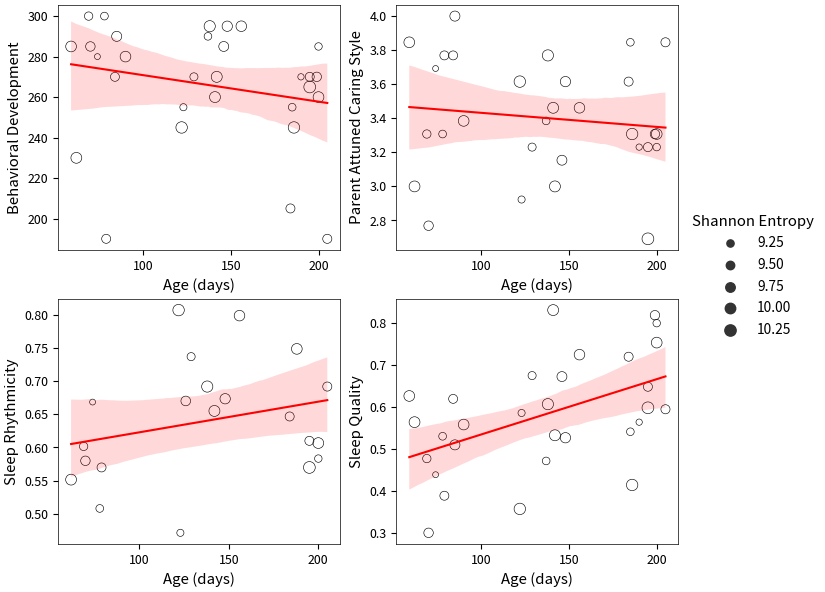

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))

for i, outcome in enumerate(outcome_measures):
    if outcome == 'age_days':
        continue
        
    current_md = metadata_with_shannon.dropna(subset=[outcome, 'shannon_entropy', 'age_days'])
    
    ax = axs.flatten()[i-1]
    if i == 4:
        sns.scatterplot(
            data=current_md,
            x='age_days',
            y=outcome,
            size="shannon_entropy",
            # palette="Blues",
            marker="o",
            facecolor="none",
            edgecolor="black",
            legend="brief",
            ax=ax
        )
        ax.legend(title="Shannon Entropy", loc='upper left', bbox_to_anchor=(1, 1.4))
    
    else:
        sns.scatterplot(
            data=current_md,
            x='age_days',
            y=outcome,
            size="shannon_entropy",
            # palette="Blues",
            legend=False,
            marker="o",
            facecolor="none",
            edgecolor="black",
            ax=ax
        )
    
    sns.regplot(
        data=current_md,
        x='age_days',
        y=outcome,
        scatter=False,
        ax=ax,
        color='red'
    )

    ax.set_xlabel("Age (days)")
    ax.set_ylabel(outcome_measures_label_dict[outcome])

The scatterplots with regression lines above already hint to the statistical results.
Shannon diversity is not a significant factor in any of the outcome measures. It is closest for sleep rhythmicity (p-value = 0.054). Age has a significant influence on sleep quality (p-value = 0.003), which was already indicated by the high correlation of the two variables in the heatmap above.